# Stock price prediction using linear and random forest regression.

## Required Libraries

We need the following libraries:

- `yfinance`: To download historical stock data
- `pandas`, `numpy`: For data manipulation
- `matplotlib`, `seaborn`: For data visualization
- `scikit-learn`: For machine learning models

## Download Historical Stock Prices

We download daily price data for **Apple Inc. (AAPL)** from the last three years. We'll focus on the `Close` price as our target variable.


In [188]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the stock and date range
stock = 'AAPL'  # Apple Inc.
end = datetime.now()
start = end - timedelta(days=252*3)  # 3 years of trading days

# Download data
stock_data = yf.download(stock, start, end)
close_price = stock_data[['Close']].dropna()
close_price


C:\Users\julia\AppData\Local\Temp\ipykernel_30072\2037533394.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock, start, end)
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2023-06-05,177.799835
2023-06-06,177.433517
2023-06-07,176.057266
2023-06-08,178.780029
2023-06-09,179.166107
...,...
2025-06-23,201.500000
2025-06-24,200.300003


## Feature Engineering: Create Lag Features

To turn this time series into a supervised learning problem, we create new columns like:

- `Previous Day Price`
- `Price 2 Days Ago`
- ...up to `Price 5 Days Ago`

These will be our input features, and today's price will be the target.


In [189]:
# Create lag features (up to 5 days)
for i in range(1, 6):
    close_price[f'Close_Day_Minus_{i}'] = close_price['Close'].shift(i)

# Drop missing values caused by shifting
close_price = close_price.dropna()
close_price.head()


Price,Close,Close_Day_Minus_1,Close_Day_Minus_2,Close_Day_Minus_3,Close_Day_Minus_4,Close_Day_Minus_5
Ticker,AAPL,,,,,
Date,,,,,,
2023-06-12,181.968079,179.166107,178.780029,176.057266,177.433517,177.799835
2023-06-13,181.492844,181.968079,179.166107,178.780029,176.057266,177.433517
2023-06-14,182.126480,181.492844,181.968079,179.166107,178.780029,176.057266
2023-06-15,184.166092,182.126480,181.492844,181.968079,179.166107,178.780029
2023-06-16,183.086884,184.166092,182.126480,181.492844,181.968079,179.166107


## Train/Test Split
Using 80% of the data to train our model and the remaining 20% to test it.

In [190]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [f'Close_Day_Minus_{i}' for i in range(1, 6)]
target = 'Close'

X = close_price[features]
y = close_price[target]

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

## Model Training

Using two models:

- Linear Regression
- Random Forest Regressor

In [191]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

c:\Users\julia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Prediction and Evaluation
We use Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) to evaluate the predictions.

In [192]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predictions
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Evaluation
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name}:\n  Root Mean Squared Error: {rmse:.2f}\n  Mean Absolute Error: {mae:.2f}\n")

evaluate(y_test, lr_preds, "Linear Regression")
evaluate(y_test, rf_preds, "Random Forest Regressor")


Linear Regression:
  Root Mean Squared Error: 5.36
  Mean Absolute Error: 3.48

Random Forest Regressor:
  Root Mean Squared Error: 6.53
  Mean Absolute Error: 4.68



## Visualizing Predictions
We will compare the actual vs predicted closing prices.

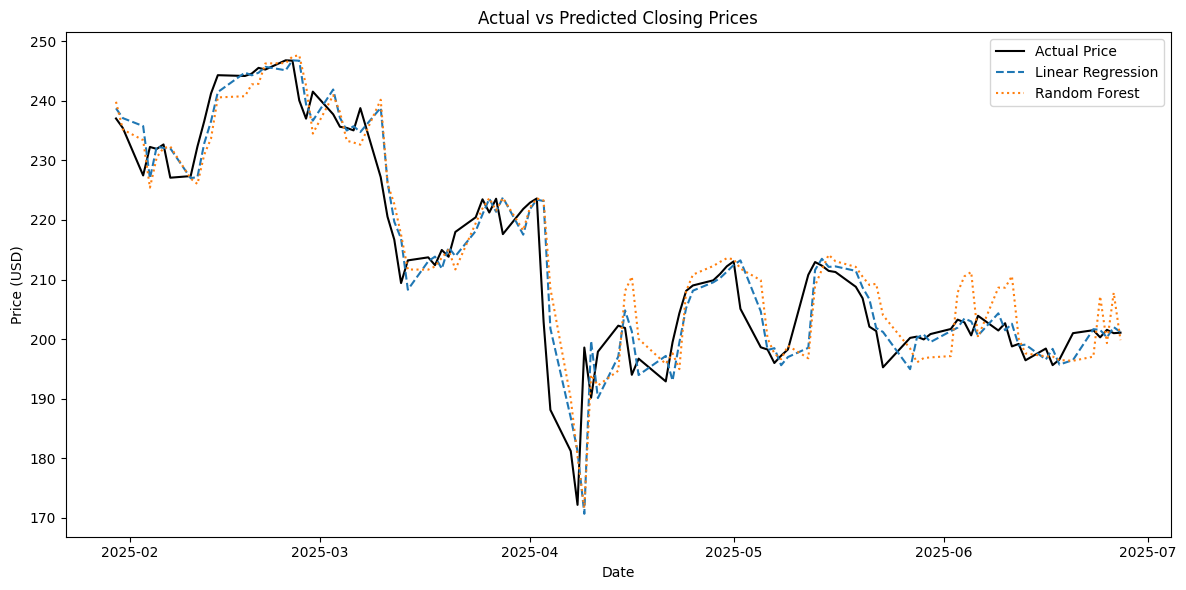

In [193]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual Price', color='black')
plt.plot(y_test.index, lr_preds, label='Linear Regression', linestyle='--')
plt.plot(y_test.index, rf_preds, label='Random Forest', linestyle=':')
plt.legend()
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()

In [194]:
import numpy as np
import pandas as pd

# Flatten predictions (ensure 1D)
lr_preds_1d = np.array(lr_preds).flatten()
rf_preds_1d = np.array(rf_preds).flatten()

# Flatten actual values (just in case)
actual_values = np.array(y_test.values).flatten()
dates = y_test.index

# Ensure all arrays are the same length
print(f"Actual: {len(actual_values)}, Dates: {len(dates)}, LR: {len(lr_preds_1d)}, RF: {len(rf_preds_1d)}")

# Now create DataFrame
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual Price': actual_values,
    'Linear Regression Prediction': lr_preds_1d,
    'Random Forest Prediction': rf_preds_1d
})

# Set Date as index (optional)
comparison_df.set_index('Date', inplace=True)

# Show the first few rows
comparison_df.iloc[-10:-1]


Actual: 103, Dates: 103, LR: 103, RF: 103


,Actual Price,Linear Regression Prediction,Random Forest Prediction
Date,,,
2025-06-13,196.449997,199.076214,197.604098
2025-06-16,198.419998,196.588235,197.110264
2025-06-17,195.639999,198.367766,197.072024
2025-06-18,196.580002,195.730526,196.483025
2025-06-20,201.000000,196.493093,196.371901
2025-06-23,201.500000,201.669584,197.062631
2025-06-24,200.300003,201.542734,207.184686
2025-06-25,201.559998,200.285285,199.335503
2025-06-26,201.000000,202.018138,207.784449


## Forecasting

In [195]:
from datetime import datetime, timedelta

# Returns the next valid trading day (skipping weekends)
def next_weekday(start_date, n=1):
    d = start_date
    for _ in range(n):
        d += timedelta(days=1)
        while d.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
            d += timedelta(days=1)
    return d

In [196]:
# Re-initialize the rolling window with most recent 5 prices
rolling_window = list(close_price['Close'].iloc[-5:].values[::-1])

# Store results
rf_preds = []
lr_preds = []
dates = []

for i in range(5):
    input_df = pd.DataFrame([rolling_window[:5]], columns=features)
    
    # Predict with both models
    rf_price = rf_model.predict(input_df)[0]
    lr_price = lr_model.predict(input_df)[0]
    
    rf_preds.append(rf_price)
    lr_preds.append(lr_price)
    
    # Add next date
    next_day = next_weekday(datetime.now(), i + 1)
    dates.append(next_day)
    
    # Update rolling window for next prediction
    rolling_window = [rf_price] + rolling_window[:4]  # or use lr_price if you want to roll LR too

c:\Users\julia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\julia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, b

C:\Users\julia\AppData\Local\Temp\ipykernel_30072\1548648761.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\julia\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


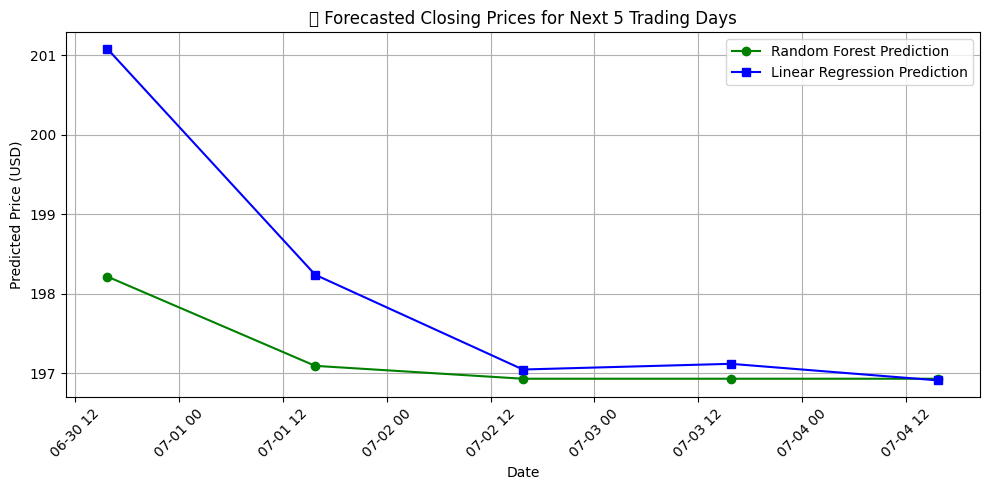

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(dates, rf_preds, marker='o', label='Random Forest Prediction', color='green')
plt.plot(dates, lr_preds, marker='s', label='Linear Regression Prediction', color='blue')

plt.title("📈 Forecasted Closing Prices for Next 5 Trading Days")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [198]:
# Prediction dataframe.
forecast_df = pd.DataFrame({
    'Date': [d.strftime('%Y-%m-%d') for d in dates],
    'Random Forest Prediction': rf_preds,
    'Linear Regression Prediction': lr_preds
})

# Display nicely
print(forecast_df)

         Date  Random Forest Prediction Linear Regression Prediction
0  2025-06-30                198.215688          [201.0782548349282]
1  2025-07-01                197.094181          [198.2394369216877]
2  2025-07-02                196.932347         [197.04824882309345]
3  2025-07-03                196.932347         [197.11979760203243]
4  2025-07-04                196.932347         [196.91128759518537]
